bactest trailing stop dataset 1 minute
2025-01-01 08:26:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94217.01408
2025-01-01 08:27:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94174.45632
2025-01-01 08:28:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94050.432
2025-01-01 09:12:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 93994.27631999999
2025-01-01 09:13:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 93963.67344
2025-01-01 09:18:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 93933.504
2025-01-01 09:23:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 93918.84768
2025-01-01 09:24:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 93862.944
2025-01-01 09:25:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 93810.64895999999
2025-01-01 09:26:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 93631.104
2025-01

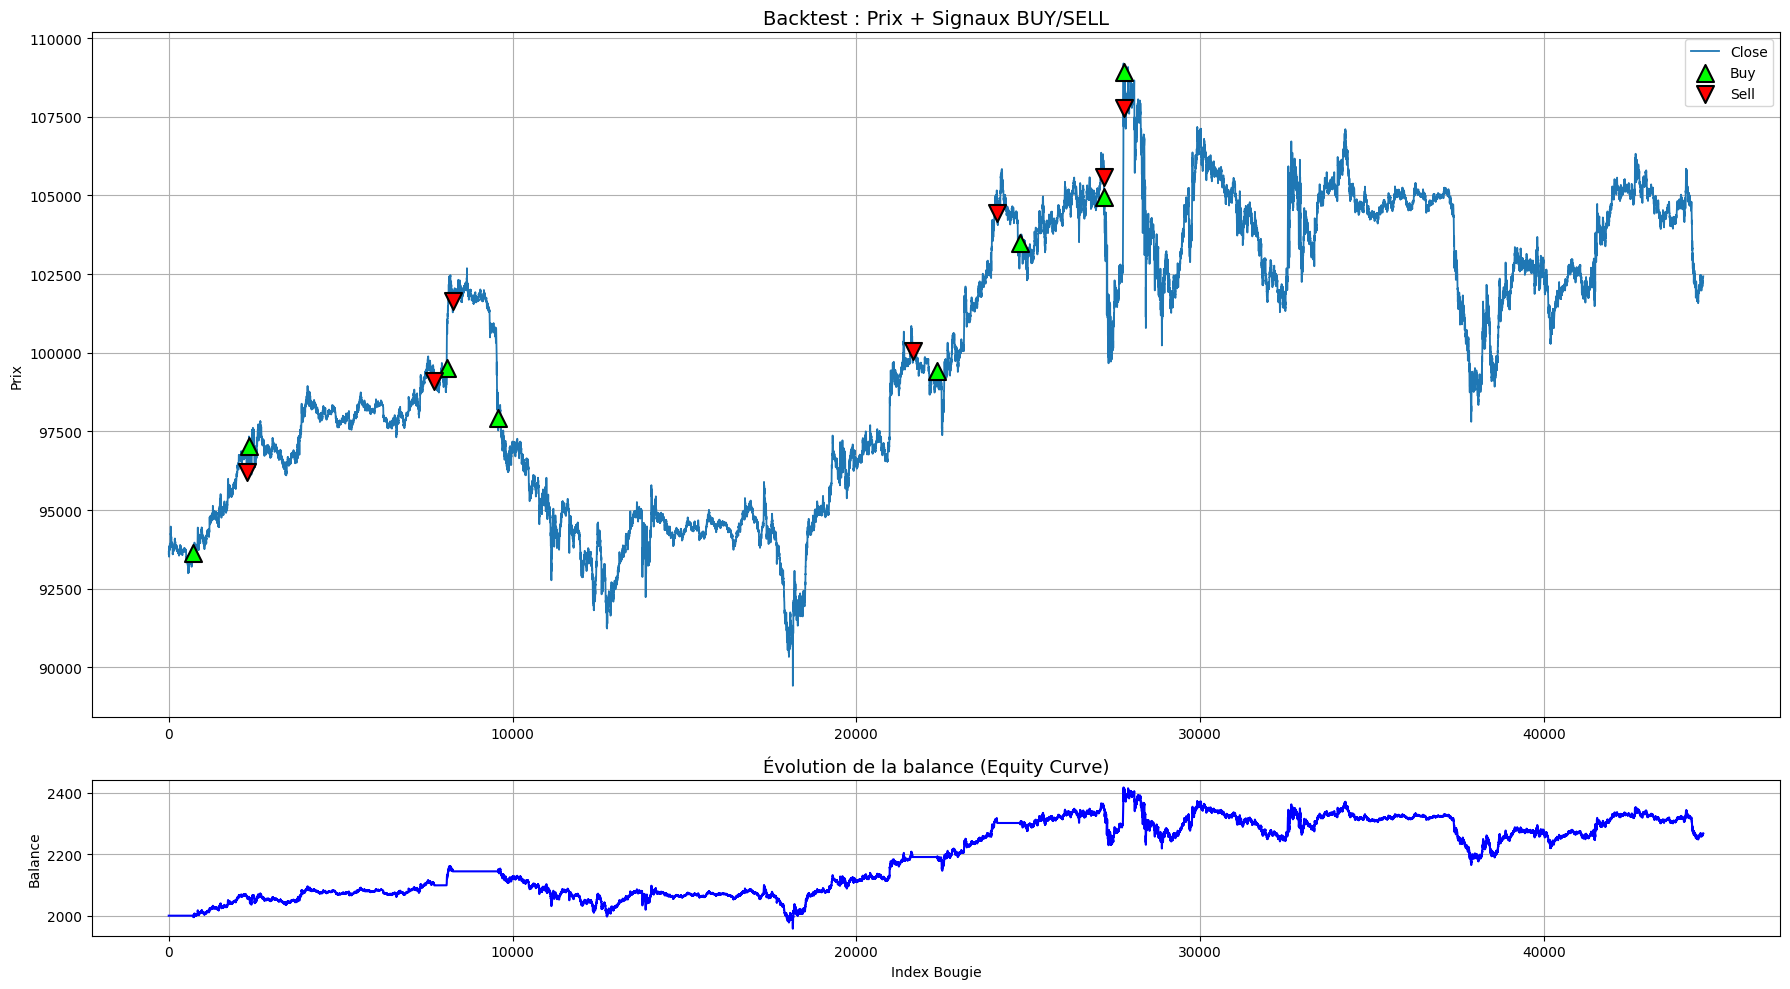

bactest trailing stop dataset 5 secondes
2025/01/01 04:59:15 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94248.0
2025/01/01 08:26:55 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94217.01408
2025/01/01 08:27:00 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94185.0
2025/01/01 08:27:10 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94184.75808
2025/01/01 08:27:15 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94174.45632
2025/01/01 08:28:30 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94157.65295999999
2025/01/01 08:28:50 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94134.67056000001
2025/01/01 08:28:55 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94050.432
2025/01/01 09:12:45 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94025.85695999999
2025/01/01 09:12:50 - Changement de la valeur du Stop Loss Achat - Trailing Stop : 94021.2
2025/

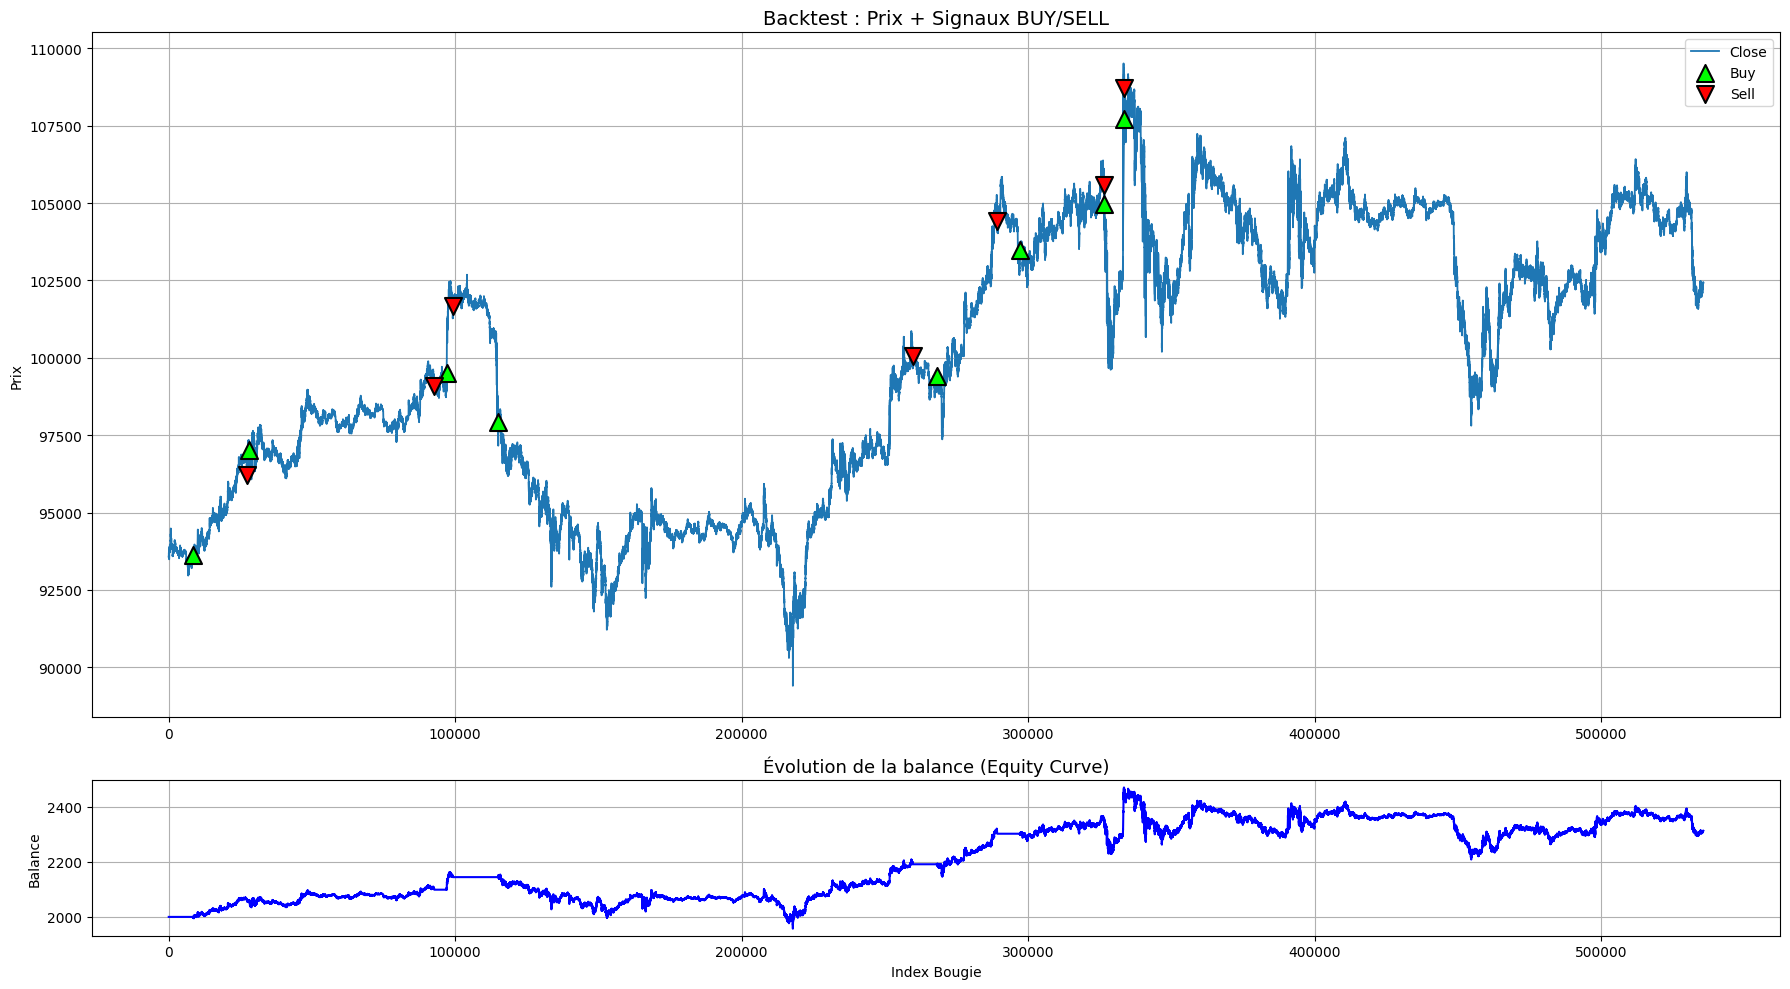

bactest simple dataset 5 secondes
2025/01/01 04:59:10 - Achat au prix de 93564.32579999999, Prix de revente au moins à 95435.612316
2025/01/02 01:07:00 - Vente au prix de 95435.612316
2025/01/02 14:04:20 - Achat au prix de 96018.1695, Prix de revente au moins à 97938.53289
2025/01/03 16:22:05 - Vente au prix de 97938.53289
2025/01/04 00:36:15 - Achat au prix de 97987.1409, Prix de revente au moins à 99946.883718
2025/01/06 14:48:35 - Vente au prix de 99946.883718
2025/01/06 17:40:50 - Achat au prix de 101455.2, Prix de revente au moins à 103484.304
2025/01/17 15:03:15 - Vente au prix de 103484.304
2025/01/17 17:44:15 - Achat au prix de 104216.5476, Prix de revente au moins à 106300.87855200001
2025/01/19 20:04:00 - Vente au prix de 106300.87855200001
2025/01/19 21:24:50 - Achat au prix de 105358.20569999999, Prix de revente au moins à 107465.36981399999
2025/01/20 06:52:05 - Vente au prix de 107465.36981399999
2025/01/20 06:56:25 - Achat au prix de 108492.12, Prix de revente au moins à

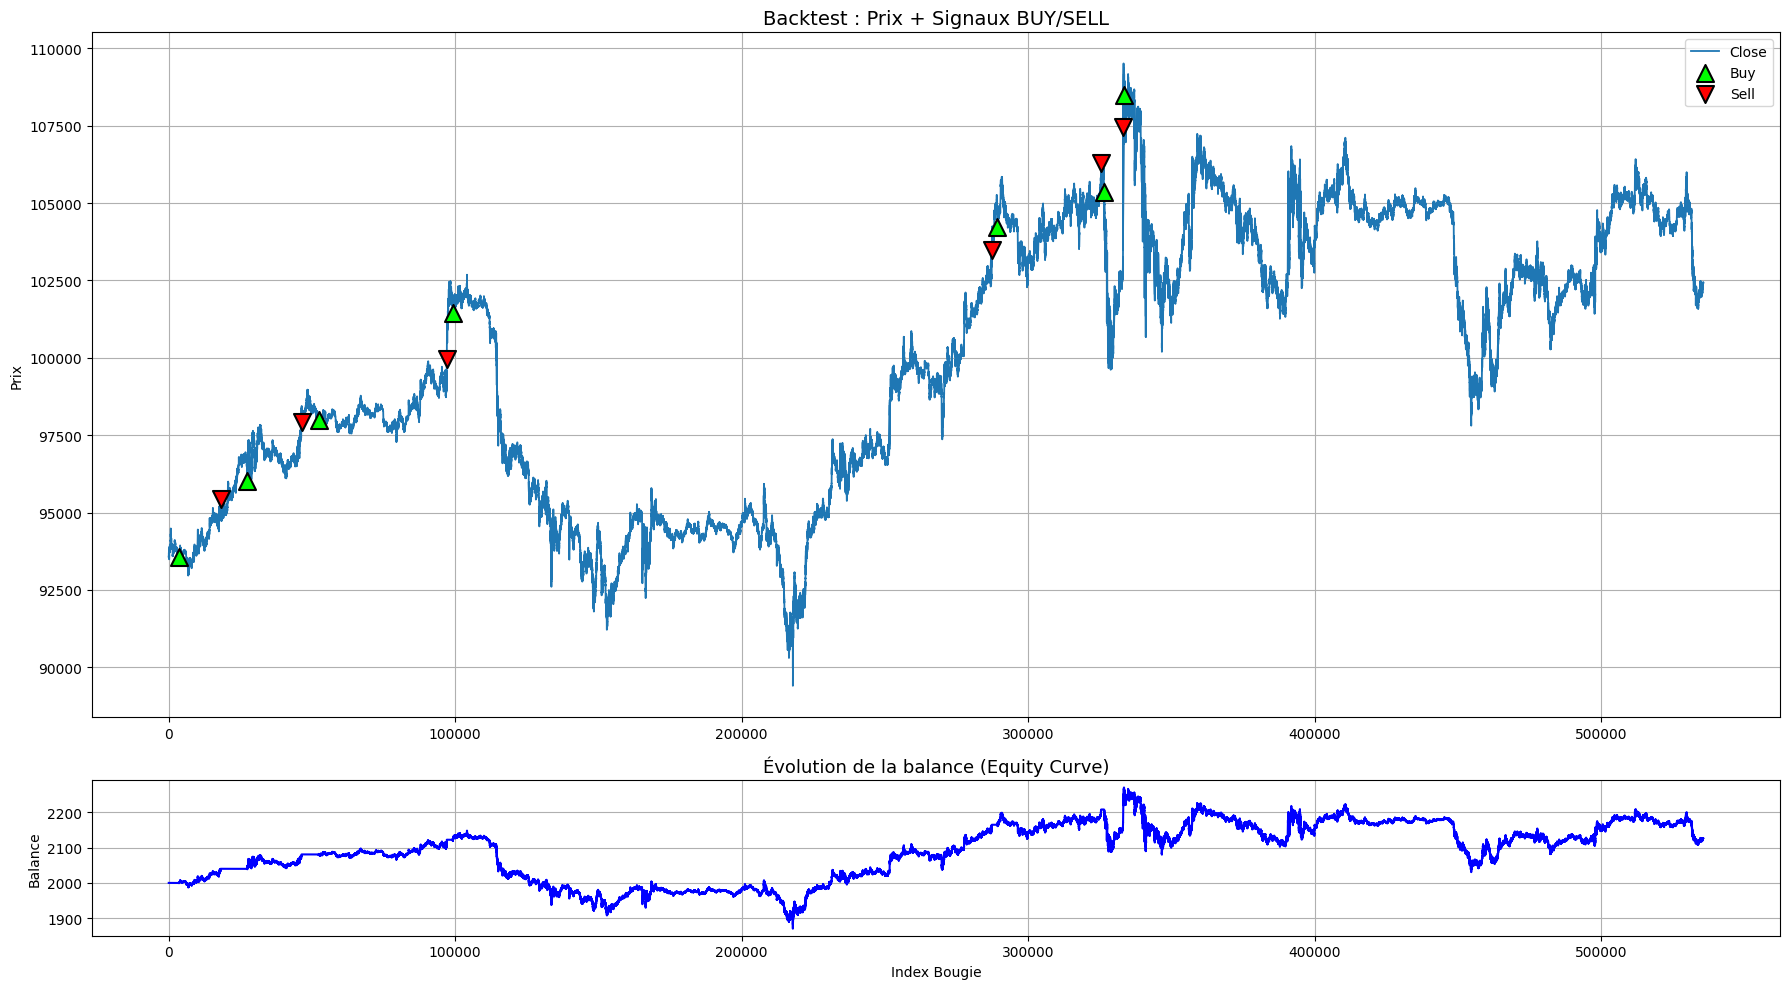

In [206]:
import csv
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


### Constante : Pourcentage Trailing Stop
PCTTRAILINGSTOP = 0.008
### Après achat, prix initial de vente
PRIXINITSELL = 1.02
### A partir du prix max visualisé, potentiel d'achat à 99% du prix max
PCTINITPRICEMAX = 0.99

### Création de la class Candle
@dataclass
class Candle:
    timestamp: str
    open: float
    high: float
    low: float
    close: float
    volume: float

### Fonction pour chargé le dataset
def load_candles(filepath: str) -> List[Candle]:
    candles: List[Candle] = []

    with open(filepath, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter=';')

        for line_number, row in enumerate(reader, start=1):
            try:
                ts = row["Timestamp"]
                o = float(row["Open"])
                h = float(row["High"])
                l = float(row["Low"])
                c = float(row["Close"])
                v = float(row.get("Volume", 0.0))

                candle = Candle(
                    timestamp=ts,
                    open=o,
                    high=h,
                    low=l,
                    close=c,
                    volume=v
                )
                candles.append(candle)

            except Exception as e:
                print(f"Erreur parsing ligne {line_number}: {e}")
                continue

    return candles

def backtestSimple(candles):
    maxPrice = 0.0
    buy = False

    sellPrice = 0.0
    sell = False

    balance = 2000.0
    BTC = 0.0

    ### Initialisation des variables pour la création du graphique
    buy_idx = []
    buy_price = []
    sell_idx = []
    sell_price = []

    ### Initiation des variables du portefeuille => Affichage graphique
    equity_curve = []
    equity_idx = []

    ### Bouche sur chacune des lignes du dataset
    for i, c in enumerate(candles):
        ### Calcul du prix max visualisé
        maxPrice = max(c.high, maxPrice)
        ### A partir du prix max visualisé, potentiel d'achat à 99% du prix max. Exemple Prix 100000 => il faut que le prix atteinge 99000 pour démarrer la phase d'achat.
        buyPrice = maxPrice * PCTINITPRICEMAX

        if not buy:
            if c.low < buyPrice:
                ### Oui, le prix est repassé au dessus, achat réalisé.
                buy = True
                ### Calcul rapide du nombre de BTC acheté.
                BTC = balance / buyPrice
                ### Initialisation de notre prix de vente. Achat à 99000, prix de vente : 99000 * 1.02 (pctPrixInitialVente) = 100980
                sellPrice = buyPrice * PRIXINITSELL
                print(f"{c.timestamp} - Achat au prix de {buyPrice}, Prix de revente au moins à {sellPrice}")

                ### valeur pour graphique.
                buy_idx.append(i)
                buy_price.append(buyPrice)
        
        if buy :
            if c.high > sellPrice:
                ### Oui, le prix est repassé au dessus du prix de 100980, vente réalisé.
                sell = True
                ### Calcul rapide de la balance après vente du BTC au prix
                balance = BTC * sellPrice
                print(f"{c.timestamp} - Vente au prix de {sellPrice}")

                ### Valeur pour graphique
                sell_idx.append(i)
                sell_price.append(sellPrice)
        
        ### Une vente a t'elle eue lieu ?
        if sell:
            ### Oui, réinitialisation complète de toutes les variables d'achat et de vente.
            maxPrice = 0.0
            buy = False

            sell = False
            sellPrice = 0.0
            BTC = 0.0
        
        equity = BTC * c.close if buy else balance

        equity_idx.append(i)
        equity_curve.append(equity)

    print(f"Balance : {balance}")

    return {
        "balance": balance,
        "BTC": BTC,
        "buy_idx": buy_idx,
        "buy_price": buy_price,
        "sell_idx": sell_idx,
        "sell_price": sell_price,
        "equity_idx": equity_idx,
        "equity_curve": equity_curve,
    }

### Fonction du backtest
def backtestTrailing(candles):
    ### initialisation de la variable maxPrice => Recherche du plus haut prix pour définir un prix d'achat à 1%
    maxPrice = 0.0

    ### Initialisation des variables d'achat
    ### Entry Low Price : Le prix le plus bas atteint.
    EntryLowPrice = 0.0
    ### Trailing Stop : On prend le prix le plus bas (EntryLowPrice) et on y ajoute 0.8%
    TrailingStopBuy = 0.0
    ### Est-ce que le programme a acheté ?
    buy = False
    
    ### Initialisation des variables de vente.
    ### Entry Max Price : Le prix le plus haut atteint
    EntryMaxPrice = 0.0
    ### Trailing Stop : On prend le prix le plus haut (EntrymaxPrice) et on y soustrait 0.8%
    TrailingStopSell = 0.0
    ### Est-ce que le programme a vendu
    sell = False
    ### Price de vente initial après achat. (price d'achat * pctPrixInitialVente)
    sellPrice = 0.0

    ### Notre portefeuille
    balance = 2000.0
    ### Nombre de BTC que l'on a
    BTC = 0.0

    ### Initialisation des variables pour la création du graphique
    buy_idx = []
    buy_price = []
    sell_idx = []
    sell_price = []

    ### Initiation des variables du portefeuille => Affichage graphique
    equity_curve = []
    equity_idx = []

    ### Bouche sur chacune des lignes du dataset
    for i, c in enumerate(candles):
        ### Calcul du prix max visualisé
        maxPrice = max(c.high, maxPrice)
        ### A partir du prix max visualisé, potentiel d'achat à 99% du prix max. Exemple Prix 100000 => il faut que le prix atteinge 99000 pour démarrer la phase d'achat.
        buyPrice = maxPrice * PCTINITPRICEMAX

        ### pas encore acheté ? Calcul en cours
        if not buy:
            ### TrailingStop à 0 et le prix c.low est inférieur au prix d'achat. Exemple, 98500
            if TrailingStopBuy == 0 and c.low < buyPrice:
                ### le prix le plus bas est actuellement c.low, initialisation de EntryLowPrice
                EntryLowPrice = c.low
                ### Calcul du Trailing Stop Buy, 98500 * (1 + 0.008) (PCTTRAILINGSTOP) = 99288
                TrailingStopBuy = EntryLowPrice * (1 + PCTTRAILINGSTOP)

            ### Trailing Stop supérieur à 0, le programme est en phase d'achat. Trailing Stop positionné
            if TrailingStopBuy > 0:
                ### Est-ce que le prix continue de chuter ? Oui, le prix est à 98000
                if c.low < EntryLowPrice:
                    ### c.low est inférieur à notre entrée Low Price, on met à jour EntryLowPrice avec la valeur la plus basse du prix 98000
                    EntryLowPrice = c.low
                    ### Recalcul du Trailing Stop suivant la tendance vers le bas 98000 * (1 + 0.008) (PCTTRAILINGSTOP) = 98784
                    TrailingStopBuy = EntryLowPrice * (1 + PCTTRAILINGSTOP)
                    print(f"{c.timestamp} - Changement de la valeur du Stop Loss Achat - Trailing Stop : {TrailingStopBuy}")

                ### Le prix remonte, est-ce que le prix max de la bougie est au dessus de 98784
                if c.high > TrailingStopBuy:
                    ### Oui, le prix est repassé au dessus, achat réalisé.
                    buy = True
                    ### Calcul rapide du nombre de BTC acheté.
                    BTC = balance / TrailingStopBuy
                    ### Initialisation de notre prix de vente. Achat à 98784, prix de vente : 98784 * 1.02 (PRIXINITSELL) = 100760
                    sellPrice = TrailingStopBuy * PRIXINITSELL * (1 + PCTTRAILINGSTOP)
                    print(f"{c.timestamp} - Achat au prix de {TrailingStopBuy}, Prix de revente au moins à {sellPrice}, Stop loss {sellPrice * (1 - PCTTRAILINGSTOP)}")

                    ### valeur pour graphique.
                    buy_idx.append(i)
                    buy_price.append(TrailingStopBuy)
        
        ### Si achat réalisé. vente en cours...
        if buy:
            ### TrailingStop pas encore initialisé. Le prix haut est-il au dessus de notre prix de vente ? 100760 Oui, le prix est à 101000
            if TrailingStopSell == 0 and c.high > sellPrice:
                ### c.high est supérieur à notre entrée sellPrice, on met à jour EntryMaxPrice avec la valeur la plus haute du prix 101000
                EntryMaxPrice = c.high
                ### Calcul du Trailing Stop Sell, 101000 * (1 - 0.008) (PCTTRAILINGSTOP) = 100192
                TrailingStopSell = EntryMaxPrice * (1 - PCTTRAILINGSTOP)
            ### Trailing Stop supérieur à 0, le programme est en phase de vente. Trailing Stop positionné
            if TrailingStopSell > 0:
                ### Est-ce que le prix continue d'augmenter ? Oui, le prix est à 103000
                if c.high > EntryMaxPrice:
                    ### c.high est inférieur à notre entrée Max Price, on met à jour EntryMaxPrice avec la valeur la plus haute du prix 103000
                    EntryMaxPrice = c.high
                    ### Recalcul du Trailing Stop suivant la tendance vers le haut 103000 * (1 - 0.008) (PCTTRAILINGSTOP) = 102176
                    TrailingStopSell = EntryMaxPrice * (1 - PCTTRAILINGSTOP)
                    print(f"{c.timestamp} - Changement de la valeur du Stop Loss Vente - Trailing Stop : {TrailingStopSell} | EntryMaxPrice {EntryMaxPrice} | ")

                ### Le prix redescend après la phse de monté, est-ce que le prix low de la bougie est en dessous de 102176
                if c.low <= TrailingStopSell:
                    ### Oui, le prix est repassé en dessous, vente réalisé.
                    sell = True
                    ### Calcul rapide de la balance après vente du BTC au prix
                    balance = BTC * TrailingStopSell
                    print(f"{c.timestamp} - Vente au prix de {TrailingStopSell}")

                    ### Valeur pour graphique
                    sell_idx.append(i)
                    sell_price.append(TrailingStopSell)

        ### Une vente a t'elle eue lieu ?
        if sell:
            ### Oui, réinitialisation complète de toutes les variables d'achat et de vente.
            maxPrice = 0.0
            EntryLowPrice = 0.0
            TrailingStopBuy = 0.0
            buy = False

            EntryMaxPrice = 0.0
            TrailingStopSell = 0.0
            sell = False
            sellPrice = 0.0
            BTC = 0.0
        
        equity = BTC * c.close if buy else balance

        equity_idx.append(i)
        equity_curve.append(equity)

    print(f"Balance : {balance}")

    return {
        "balance": balance,
        "BTC": BTC,
        "buy_idx": buy_idx,
        "buy_price": buy_price,
        "sell_idx": sell_idx,
        "sell_price": sell_price,
        "equity_idx": equity_idx,
        "equity_curve": equity_curve,
    }

def plot_backtest(candles, bt_result):
    x = list(range(len(candles)))
    close_prices = [c.close for c in candles]

    buy_idx = bt_result["buy_idx"]
    buy_price = bt_result["buy_price"]
    sell_idx = bt_result["sell_idx"]
    sell_price = bt_result["sell_price"]

    equity_idx = bt_result["equity_idx"]
    equity_curve = bt_result["equity_curve"]

    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 2, 1], figure=fig)

    ax1 = fig.add_subplot(gs[0:2, 0])
    ax1.grid(True)
    ax1.plot(x, close_prices, label="Close", linewidth=1.3)

    if buy_idx:
        ax1.scatter(buy_idx, buy_price,
                    marker="^", color="lime", edgecolors="black",
                    s=150, linewidths=1.5, label="Buy", zorder=10)

    if sell_idx:
        ax1.scatter(sell_idx, sell_price,
                    marker="v", color="red", edgecolors="black",
                    s=150, linewidths=1.5, label="Sell", zorder=10)

    ax1.set_title("Backtest : Prix + Signaux BUY/SELL", fontsize=14)
    ax1.set_ylabel("Prix")
    ax1.legend()

    ax2 = fig.add_subplot(gs[2, 0])
    ax2.grid(True)
    ax2.plot(equity_idx, equity_curve, linewidth=1.5, color="blue")
    ax2.set_title("Évolution de la balance (Equity Curve)", fontsize=13)
    ax2.set_xlabel("Index Bougie")
    ax2.set_ylabel("Balance")

    plt.tight_layout()
    plt.show()


### Lire les 5 premières lignes du fichier, vérification.
def readFileBacktest(candles):
    print(f"Nombre de bougies chargées : {len(candles)}")
    for i, c in enumerate(candles[:5], start=1):
        print(
            f"{i} | {c.timestamp} | O:{c.open} H:{c.high} "
            f"L:{c.low} C:{c.close} V:{c.volume}"
        )
    print()

    

def main():
    print("bactest trailing stop dataset 1 minute")
    filepath = "BTCUSDT_1m_2025_01.csv"
    candles = load_candles(filepath)
    #readFileBacktest(candles)
    bt_result = backtestTrailing(candles)
    plot_backtest(candles, bt_result)

    print("bactest trailing stop dataset 5 secondes")
    filepath = "BTCUSDT_2025_01_avg5s.csv"
    candles = load_candles(filepath)
    #readFileBacktest(candles)
    bt_result = backtestTrailing(candles)
    plot_backtest(candles, bt_result)

    print("bactest simple dataset 5 secondes")
    filepath = "BTCUSDT_2025_01_avg5s.csv"
    candles = load_candles(filepath)
    #readFileBacktest(candles)
    bt_result = backtestSimple(candles)
    plot_backtest(candles, bt_result)


if __name__ == "__main__":
    main()
